# TD 8 - 01/02/2021

Marta Lazzaretti: lazzaretti@i3s.unice.fr


In [54]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from numpy.linalg import norm
from practice08 import *


In [55]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Forward model: blurring and downsampling operator

In SMLM type data, the acquisition consist of a blurred, undersampledlorenzo and noisy image of a molecule sample (the ground truth image).
Let $x\in\mathbb R^{n^2}$ be the ground truth image.
The microscope only allows us to have access to a blurred, undersampled and noisy version $$y=Ax+\eta,$$
where $A:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}, n=Ln,$ is the forward (blurring+undersampling) operator and $\eta\in\mathbb R^{m^2}$ is a Gaussian distributed noisy vector with $0$ mean and variance $\sigma^2$: $\eta\sim\mathcal N(0,\sigma^2)$. $L>0$ is called super-resolution factor: the acquisition $y\in\mathbb R^{m^2}$ lives in a $L^2$ coarser grid than the ground truth $x\in\mathbb R^{n^2}$.

Given the acquisition $y\in\mathbb R^{m^2}$, we aim at reconstructing the ground truth $x\in\mathbb R^{n^2}$. To do so, we need to know how to model the forward operator $A$ (that is we need to know how our microscope works).

The forward operator can be modeled as $A=M_L*H$ where

1. $H:\mathbb R^{n^2} \longrightarrow \mathbb R^{n^2}$ is the blurring operator and can be implemented as a convolution with the PSF (as seen in TD 6)

2. $M_L:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}$ is the undersampling operator which takes an image in the finer grid and maps it in an image in the coarser grid, averaging the values on $L\times L$ patches of pixels.


Generate a ground truth image of dimensions $n\times n$, with a fixed number of molecules $N_{mol}$, placed at random in the sample. For simplicity, we choose not to place them too close to the border and stay $margin$ pixels away from it.


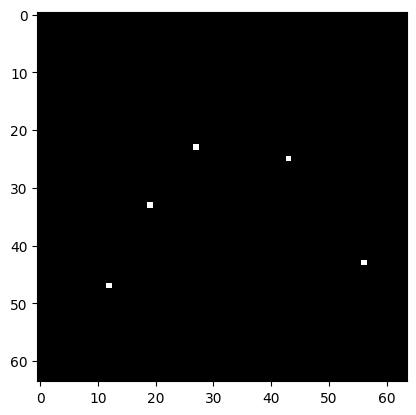

In [56]:
# ground truth image
n = 64  # size of the image
gt = np.zeros([n, n])
n_mol = 5  # choose the number of molecules
margin = 5  # choose the empty margin
np.random.seed(42)

for k in np.arange(n_mol):
  i = np.random.randint(low=margin, high=n - margin)
  j = np.random.randint(low=margin, high=n - margin)
  gt[i, j] = 255

# plot the image
plt.imshow(gt, cmap="gray")
plt.show()


Now implement the forward operator. Start with the blurring operator.


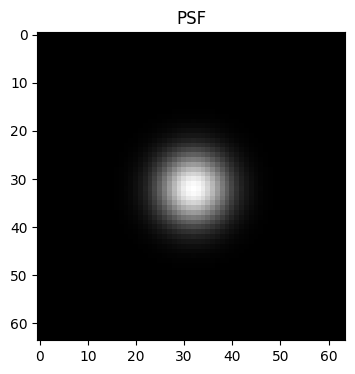

In [57]:
# convolution kernel: the point spread function PSF
s = 5  # choose a value that seems reasonable
n = np.shape(gt)[0]
x = np.concatenate((np.arange(0, n / 2), np.arange(-n / 2, 0)))
[Y, X] = np.meshgrid(x, x)
h = np.exp((-(X**2) - Y**2) / (2 * s**2))
h = h / np.sum(h)

# plot the PSF
plt.figure(figsize=(4, 4))
plt.imshow(np.fft.fftshift(h), cmap="gray")
plt.title("PSF")
plt.show()


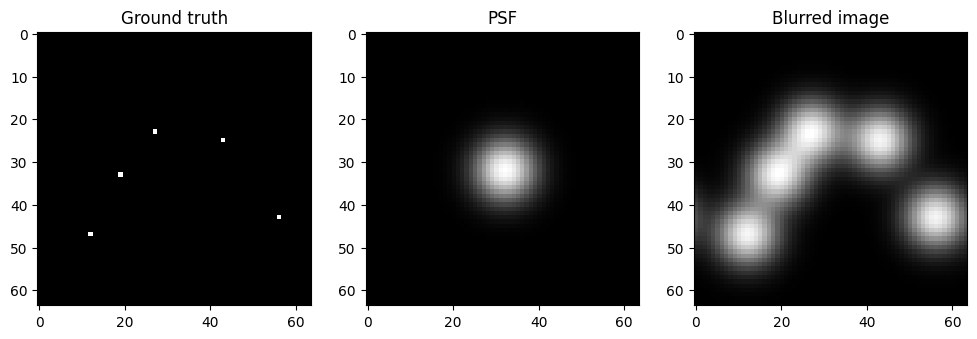

In [58]:
blurred_image = blur(gt, h)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.imshow(np.fft.fftshift(h), cmap="gray")
plt.title("PSF")
plt.subplot(1, 3, 3)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred image")
plt.show()


Now implement the downsampling matrix.


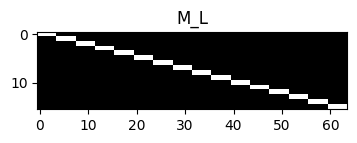

In [59]:
# super-resolution factor
L = 4
m = int(n / L)
M_L = np.zeros([m, n])
for i in np.arange(m):
  M_L[i, L * i : L * i + L] = 1

# plot the downsampling matrix
plt.figure(figsize=(4, 4))
plt.imshow(M_L, cmap="gray")
plt.title("M_L")
plt.show()


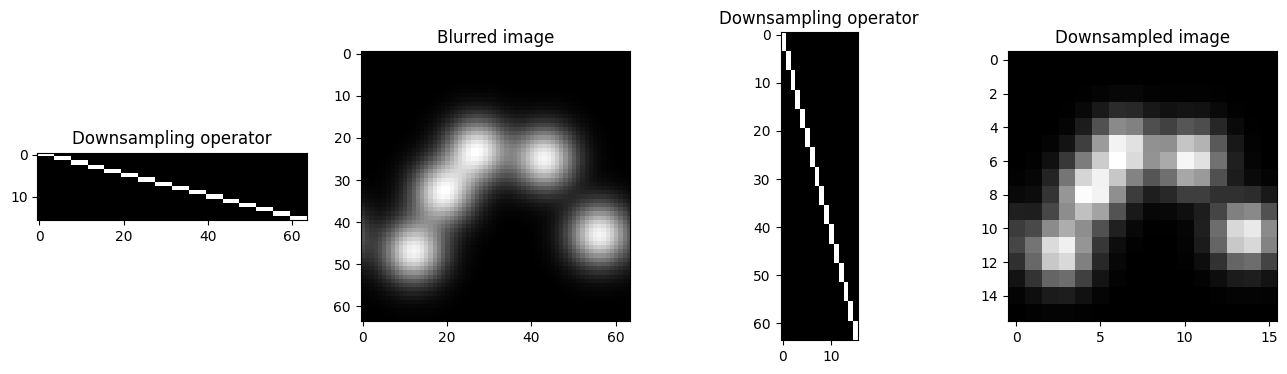

In [60]:
downsampled_image = forward(gt, h, M_L)

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(M_L, cmap="gray")
plt.title("Downsampling operator")
plt.subplot(1, 4, 2)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred image")
plt.subplot(1, 4, 3)
plt.imshow(np.transpose(M_L), cmap="gray")
plt.title("Downsampling operator")
plt.subplot(1, 4, 4)
plt.imshow(downsampled_image, cmap="gray")
plt.title("Downsampled image")
plt.show()


Generate gaussian noise and add it to the blurred and downsampled image.


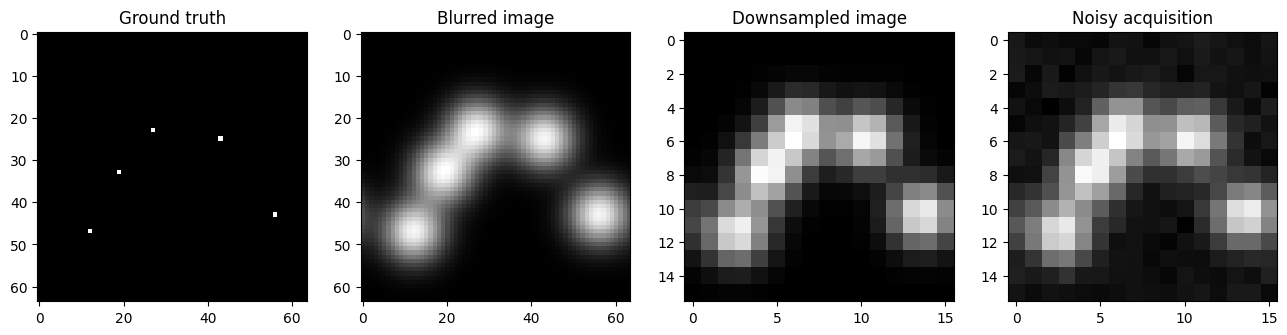

In [61]:
# in this way you will have a deterministic result
np.random.seed(24)
# generate gaussian noise
sigma_noise = 0.7
noise = sigma_noise * np.random.randn(m, m)
# add gaussian noise to the blurred image
acq = downsampled_image + noise

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 4, 2)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred image")
plt.subplot(1, 4, 3)
plt.imshow(downsampled_image, cmap="gray")
plt.title("Downsampled image")
plt.subplot(1, 4, 4)
plt.imshow(acq, cmap="gray")
plt.title("Noisy acquisition")
plt.show()


## How to solve this inverse problem? How to choose the penalty?

Let $y\in\mathbb R^{m^2}$ be a noisy acquisition and $A:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}$ the forward operator. To solve the inverse problem i.e. to find $x\in\mathbb R^{n^2}$ such that $$y=Ax+\eta$$, we use a variational approach and solve
$$ \operatorname{argmin}_{x\in\mathbb R^{n^2}} \frac{1}{2}\|Ax-y\|\_2^2+\lambda R(x) +\texttt{i}_{\ge 0}(x) $$
where $R(x)$ is the regulariser or penalty term. How can we choose it? Which kind of solutions are we looking for?

We need a regulariser which enforces sparsity in the reconstrictions: we want to find images of molecules where only a few pixels are non-zero.

To do so, we can consider the $\ell_0$ pseudo-norm
$$ \|x\|_0 = \#\{i=1,\cdot,n^2|\ x_i\not=0\}=\sum_{i=1}^{n^2} |x*i|\_0 \text{ and }|u|*{0}= \begin{cases}0 & \text { if } u=0 \\ 1 & \text { otherwise }\end{cases}$$


## Fidelity term, gradient and Lipschitz constant


In [62]:
# compute the Lipschitz constant Lips
hF = np.real(np.fft.fft2(np.fft.fftshift(h)))
Lips = np.max(hF**2) * L**2


## 1) Penalty $\ell_0$ Norm --> Iterative Hard Thresholding Algorithm (IHT)


## Play around with different initialisation points


In [63]:
# options 1: zero matrix
x01 = np.zeros([n, n])
# options 2: random matrix 
x02 = np.random.rand(n, n)
# options 3: upscaled image 
x03 = np.transpose(M_L) @ acq @ M_L
# options 4: retroprojected image 
x04 = np.real(np.fft.ifft2(np.conj(hF) * np.fft.fft2(x03)))

x0_list = [x01, x02, x03, x04]
labels = ["Zero matrix", "Random matrix", "Upscaled image", "Retroprojected image"]

Plot the different initialisation points.


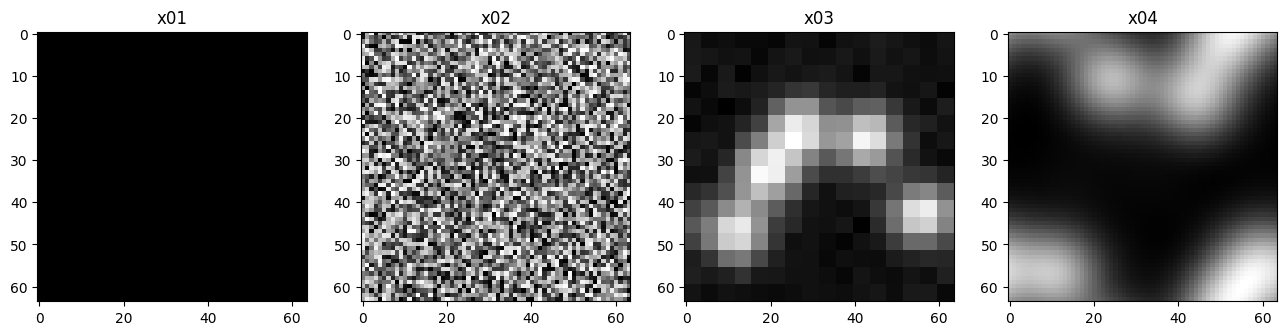

In [65]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(x01, cmap="gray")
plt.title("x01")
plt.subplot(1, 4, 2)
plt.imshow(x02, cmap="gray")
plt.title("x02")
plt.subplot(1, 4, 3)
plt.imshow(x03, cmap="gray")
plt.title("x03")
plt.subplot(1, 4, 4)
plt.imshow(x04, cmap="gray")
plt.title("x04")
plt.show()


Choose an initialisation point and compute the reconstruction. Then change initialisation and see what happens.


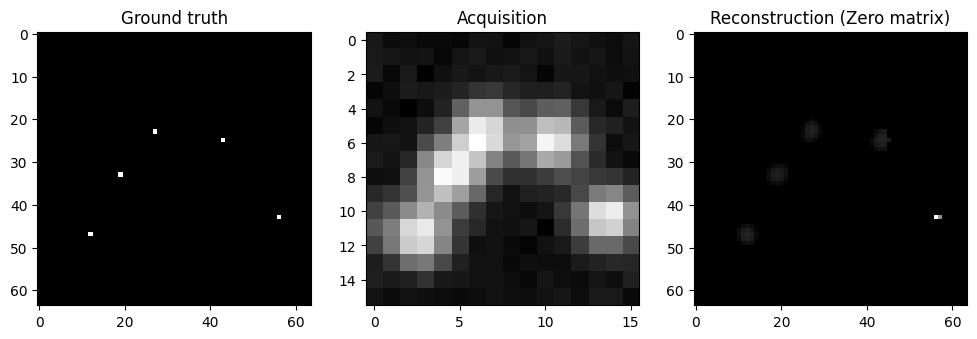

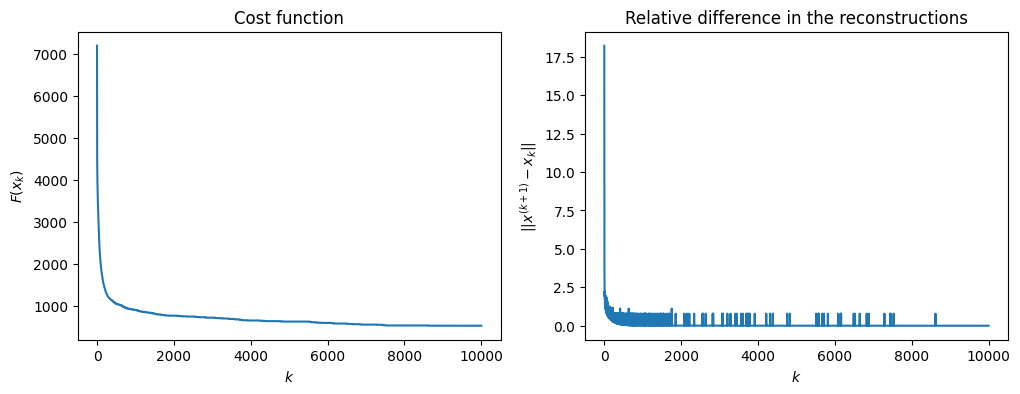

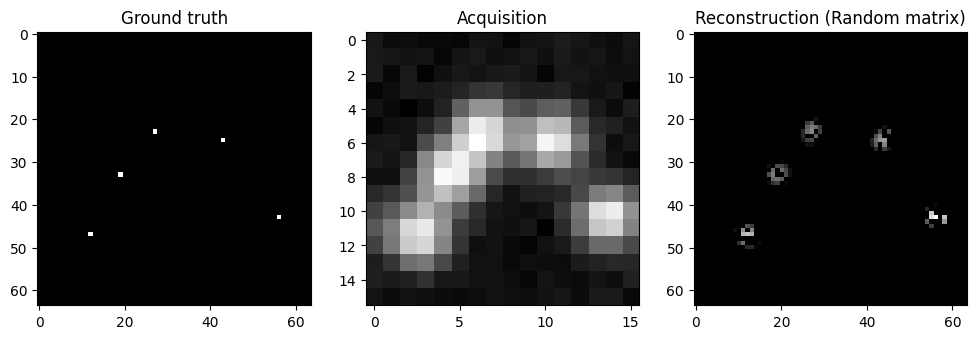

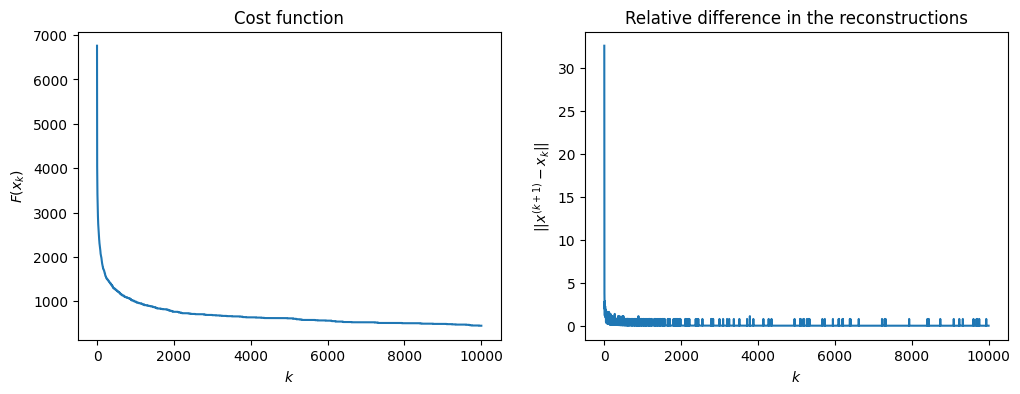

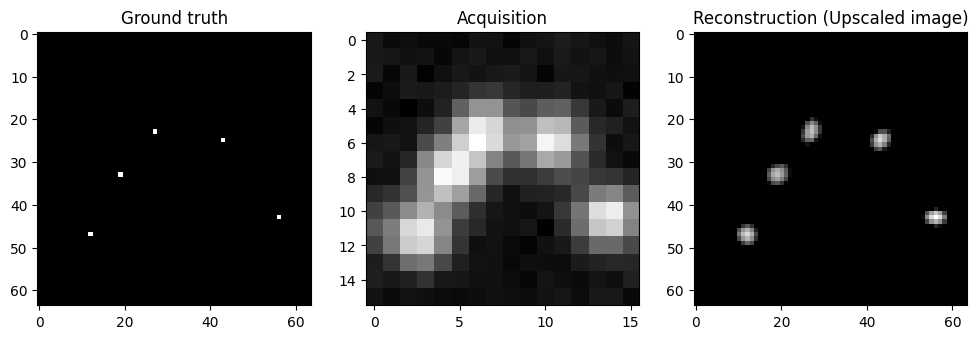

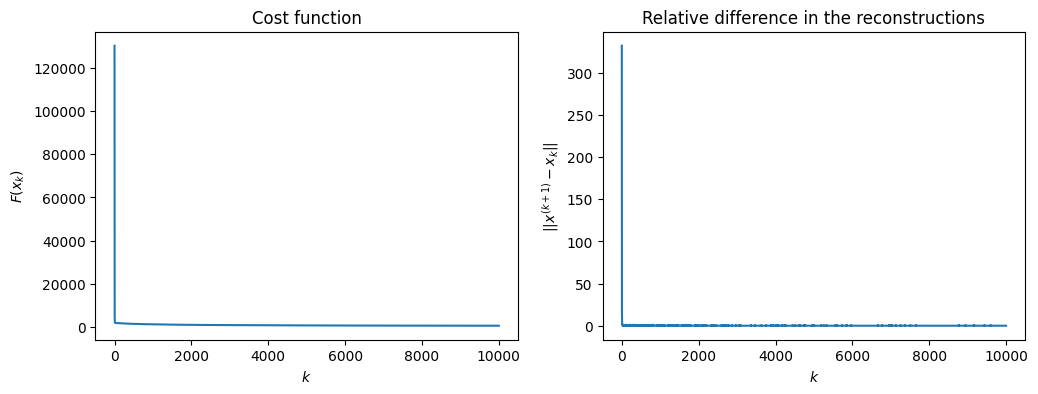

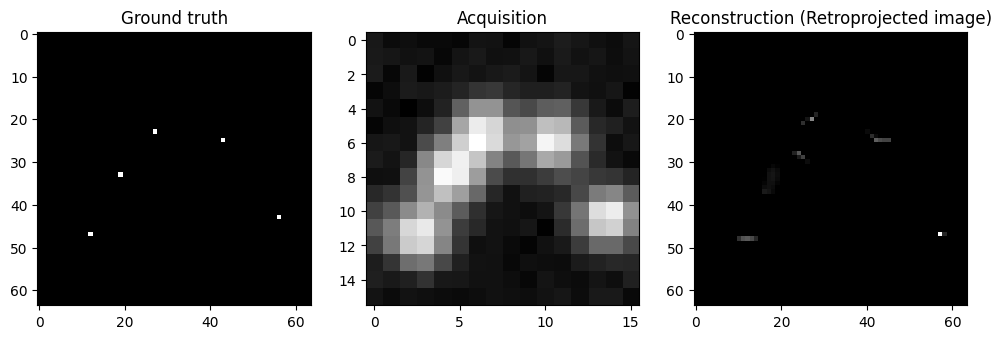

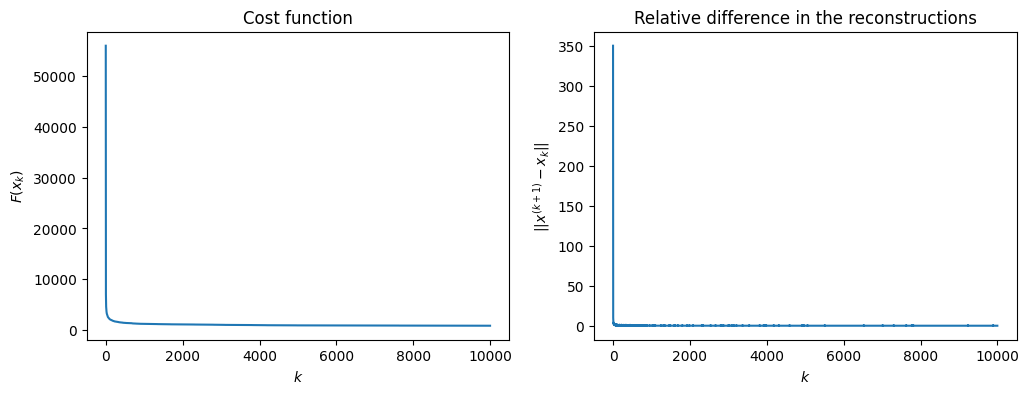

In [ ]:
x0 = x01
tau = 1 / Lips
lmbda = 5
maxiter = int(1e4)
epsilon = 1e-8

for x0, label in zip(x0_list, labels):

  # compute the reconstruction
  rec, cost, norms = IHT(x0, tau, lmbda, acq, h, M_L, epsilon, maxiter)

  # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.imshow(gt, cmap="gray")
  plt.title("Ground truth")
  plt.subplot(1, 3, 2)
  plt.imshow(acq, cmap="gray")
  plt.title("Acquisition")
  plt.subplot(1, 3, 3)
  plt.imshow(rec, cmap="gray")
  plt.title(f"Reconstruction ({label})")
  plt.show()

  # plot how the cost function decreases and how the iterates converge
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(cost)
  plt.xlabel("$k$")
  plt.ylabel("$F(x_k)$")
  plt.title("Cost function")
  plt.subplot(1, 2, 2)
  plt.plot(norms)
  plt.xlabel("$k$")
  plt.ylabel("$||x^{(k+1)}-x_{k}||$")
  plt.title("Relative difference in the reconstructions")
  plt.show()


## Relaxations to the $\ell_0$ pseudo-norm

1. $\ell_0$ pseudo-norm
   $$ \|x\|_0 = \#\{i=1,\cdot,n^2|\ x_i\not=0\}=\sum_{i=1}^{n^2} |x*i|\_0 \text{ and }|u|*{0}= \begin{cases}0 & \text { if } u=0 \\ 1 & \text { otherwise }\end{cases}$$

2. $\ell_1$ norm
   $$\|x\|_1=\sum_{i=1}^{n^2} |x_i|$$

3. Capped $\ell_1$
   $$\phi_{capped-\ell_1}(x,\theta)=\min \{\theta|x|, 1\}, \theta>0$$

4. $\ell_p$ with $0<p<1$
   $$\|x\|_p=\Big(\sum_{i=1}^{n^2} |x_i|^p\Big)^{1/p}$$

5. Log-sum: $$\phi_{log-sum}(x,\delta)=\log(\delta+|x|), \ \delta>0$$

6. Minimax Convex Penalty (MCP) with $\theta>0$ and $\lambda>0$
   $$\phi_{M C P}(x, \lambda ,\beta)=\lambda\left(\frac{\beta \lambda}{2} \mathbb{1}_{\{|x|>\beta \lambda\}}+\left(|x|-\frac{x^{2}}{2 \beta \lambda}\right) \mathbb{1}_{\{|x| \leq \beta \lambda\}}\right)$$

7. SCAD penalty with $a>2$ and $\lambda>0$
   $$ \phi\_{SCAD}(x,\lambda,a)=\begin{cases}\lambda|x| & \text { if }|x| \leqslant \lambda \\ -\frac{\lambda^{2}-2 a \lambda|x|+x^{2}}{2(a-1)} & \text { if } \lambda<|x| \leq a \lambda \\ \frac{(a+1) \lambda^{2}}{2} & \text { if }|x|>a \lambda\end{cases}$$

8. CEL0 penalty with $a>0$ and $\lambda>0$
   $$\phi_{CEL0}(x,\lambda,a)=\lambda-\frac{a^{2}}{2}\left(|x|-\frac{\sqrt{2 \lambda}}{a}\right)^{2} \mathbb{1}_{\left\{|x| \leqslant \frac{\sqrt{2 \lambda}}{a}\right\}}, \lambda>0, a>0$$


Define the above penalties as functions which take as input arrays and return arrays, computing the value of the penalties componentwise.


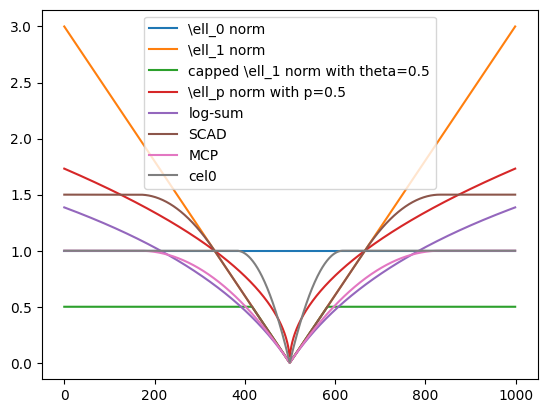

In [70]:
# plot the different penalties on the interval [-3,3]
x = np.linspace(-3, 3, num=1000)


plt.figure()
plt.plot(norm0(x), label="\ell_0 norm")
plt.plot(norm1(x), label="\ell_1 norm")
plt.plot(capped_norm1(x, 0.5), label="capped \ell_1 norm with theta=0.5")
plt.plot(normP(x, 0.5), label="\ell_p norm with p=0.5")
plt.plot(logsum(x, 1), label="log-sum")
plt.plot(SCAD(x, 1, 2), label="SCAD")
plt.plot(MCP(x, 1, 2), label="MCP")
plt.plot(CEL0(x, 1, 2), label="cel0")
plt.legend(loc="best")
plt.show()


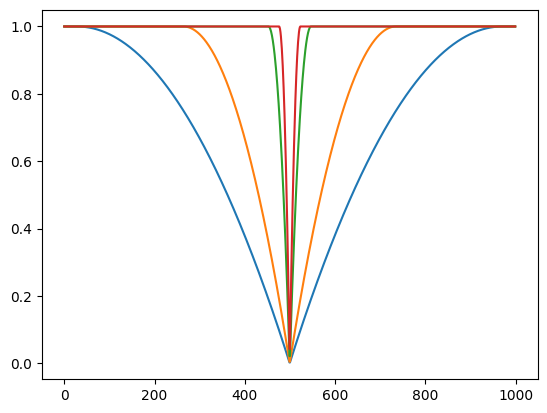

In [ ]:
# plot CEL0 penalty for different values of the parameter a
lambd = 1
a = [0.5, 1, 5, 10]
plt.figure()
for i in np.arange(np.size(a)):
  plt.plot(CEL0(x, lambd, a[i]))
plt.show()


## 2) Penalty $\ell_1$ Norm --> Iterative Soft Thresholding Algorithm (ISTA)


Choose an initialisation point and compute the reconstruction. Change it and see what happens to the reconstruction.


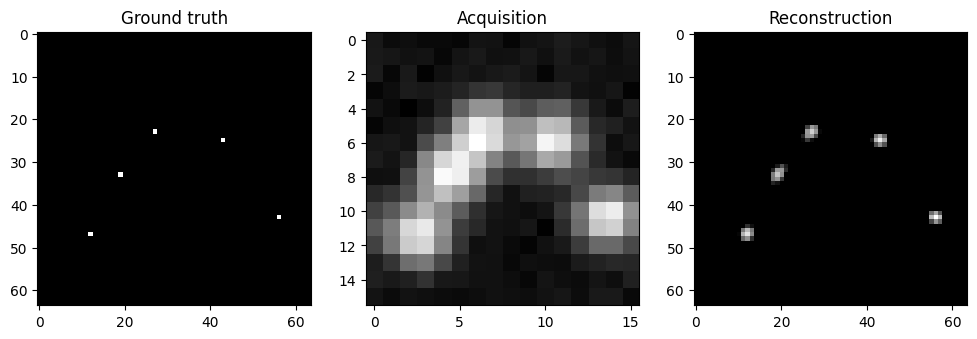

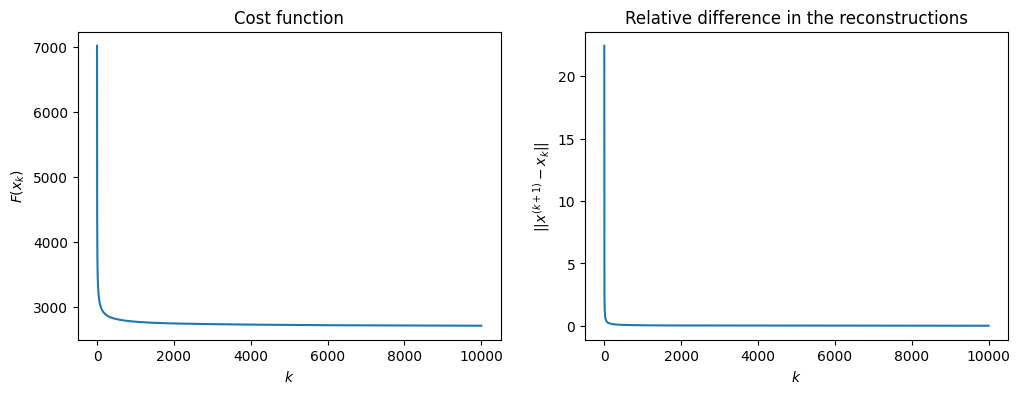

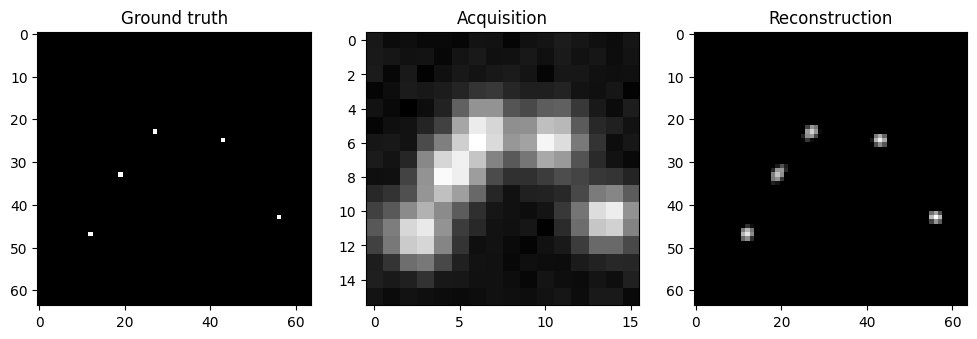

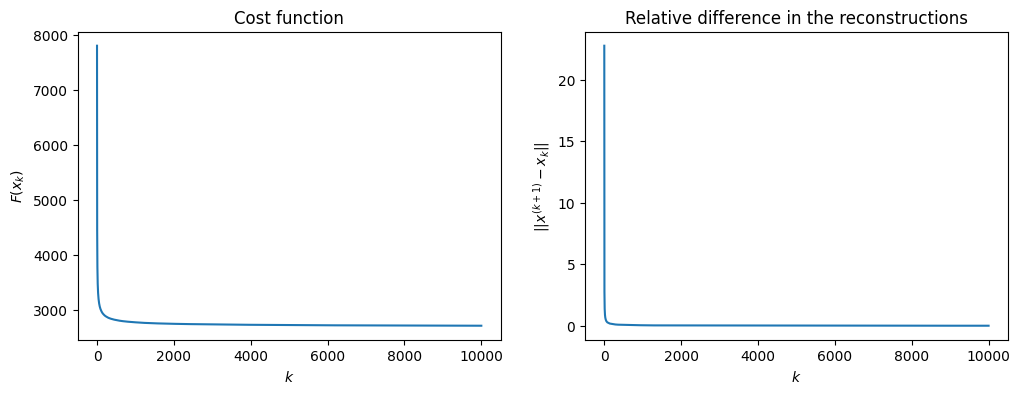

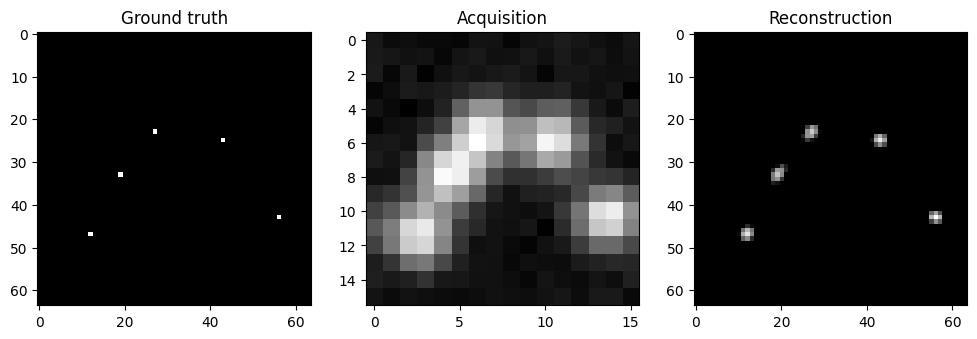

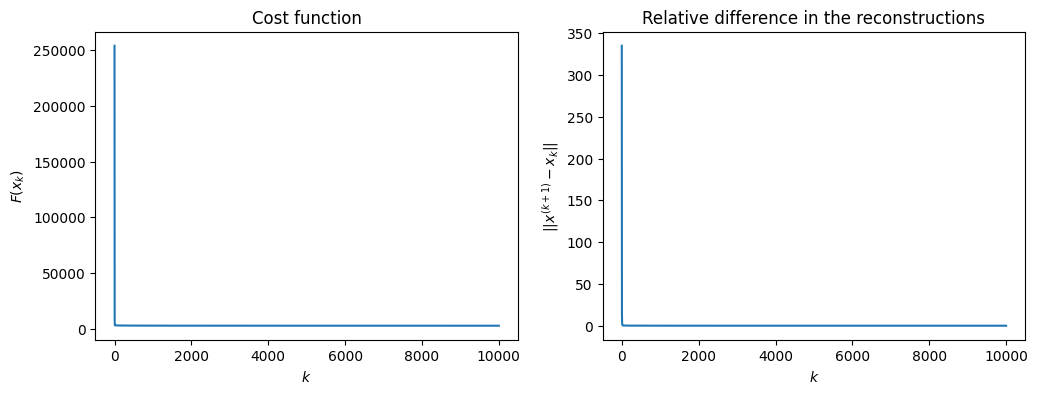

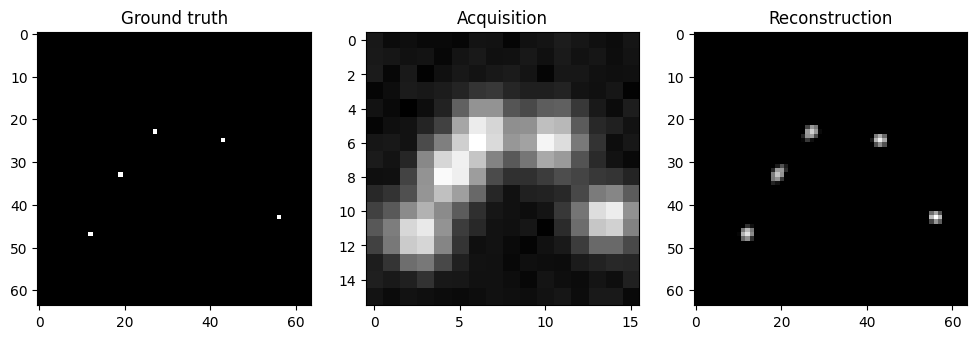

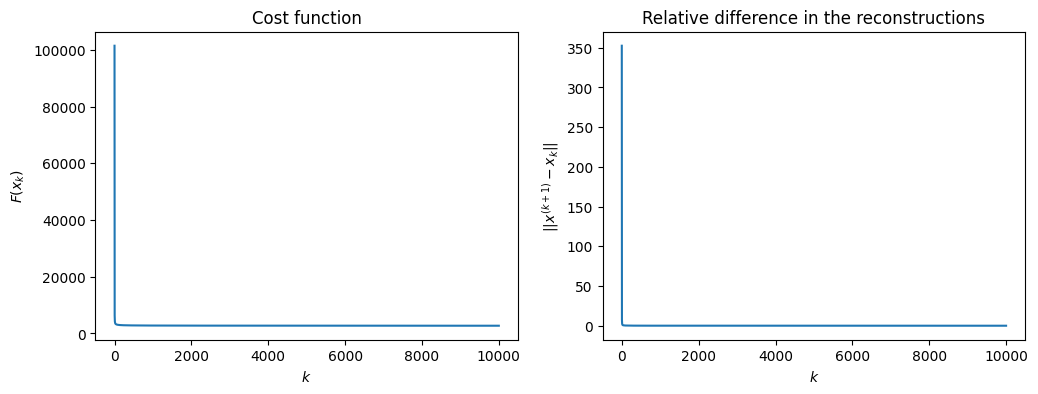

In [67]:
for x0, label in zip(x0_list, labels):
  tau = 1 / Lips
  lmbda = 2
  maxiter = int(1e4)
  epsilon = 1e-8

  # compute the reconstruction
  rec, cost, norms = ISTA(x0, tau, lmbda, acq, h, M_L, epsilon, maxiter)

  # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.imshow(gt, cmap="gray")
  plt.title("Ground truth")
  plt.subplot(1, 3, 2)
  plt.imshow(acq, cmap="gray")
  plt.title("Acquisition")
  plt.subplot(1, 3, 3)
  plt.imshow(rec, cmap="gray")
  plt.title("Reconstruction")
  plt.show()

  # plot how the cost function decreases and how the iterates converge
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(cost)
  plt.xlabel("$k$")
  plt.ylabel("$F(x_k)$")
  plt.title("Cost function")
  plt.subplot(1, 2, 2)
  plt.plot(norms)
  plt.xlabel("$k$")
  plt.ylabel("$||x^{(k+1)}-x_{k}||$")
  plt.title("Relative difference in the reconstructions")
  plt.show()


## Proximity operators of non-convex functions

Go to http://proximity-operator.net/nonconvexfunctions.html

You can find the analytical expression, matlab codes and python codes.


## 3) CEL0 penalty --> Forward-Backward Splitting algorithm

$$\Phi_{CEL0}(x,\lambda,A):=\sum_{i=1}^{n^2}\phi_{CEL0}(x_i,\lambda,||a_i||_2)=\sum_{i=1}^{n^2} \lambda -\frac{||a_i||_2^2}{2}\left(|x_i|-\frac{\sqrt{2\lambda}}{||a_i||_2}\right)^2 \delta_{\{|x_i|<\frac{\sqrt{2\lambda}}{||a_i||_2} \}}$$

Compute the values of $\|a_i\|_2^2$ for $i=1,\cdots,n^2$. Please note that $a_i\in\mathbb R^{m^2}$, where $m=n/L$.


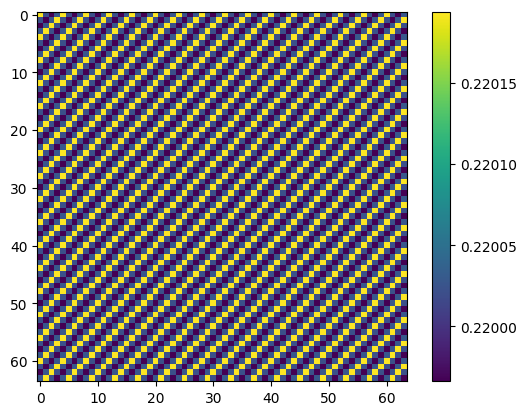

In [68]:
normai = np.zeros([L, L])
for i in np.arange(L):
  for j in np.arange(L):
    matr = M_L @ np.transpose(np.roll(h, [j, i])) @ np.transpose(M_L)
    normai[i, j] = np.linalg.norm(matr)
normai = np.matlib.repmat(normai, m, m)

plt.figure()
plt.imshow(normai)
plt.colorbar()
plt.show()


The proximity operator of the 1-dimensional $\phi_{CEL0}(x,\lambda,a)$ is given by:
$$ \operatorname{prox}_{\gamma \phi}(x)=\begin{cases}\operatorname{sign}(x) \min \left\{|x|, \frac{\max \{|x|-\sqrt{2 \lambda} \gamma a, 0\}}{1-a^{2} \gamma}\right\} & \text { if } a^{2} \gamma<1 \\ x 1_{\{|x|>\sqrt{2 \gamma \lambda}\}}+\{0, x\} 1\_{\{|x|=\sqrt{2 \gamma \lambda}\}} & \text { if } a^{2} \gamma \geqslant 1\end{cases}$$

In practice, only the case $a^{2} \gamma<1$ is needed.


In [ ]:
def prox_CEL0(x,gamma,lambd,normai):
    ??????

In [ ]:
# input parameters
# x0 is the initialisation point
# tau is the stepsize
# lambda is the regolarisation parameter
# y is the acquisition, M_L is the downsampling matrix, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion

def FB_CEL0(x0,tau,lmbda,y,h,M_L,normai,epsilon,maxiter):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):
        
        ?????????
        
        # compute the cost function
        cost[k] = cost_function_CEL0(xkk,h,M_L,y,lmbda,normai)
        norms[k] = np.linalg.norm(xkk-xk)
        # update the iteration
        xk = xkk
        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
    return xk , cost, norms

Choose an initialisation point and compute the reconstruction. Change it and see what happens to the reconstruction.


In [ ]:
x0 = ?????????????
tau = 1/Lips
lmbda = 2
maxiter = int(1e4)
epsilon = 1e-8

# compute the reconstruction
rec, cost, norms = FB_CEL0(x0,tau,lmbda,acq,h,M_L,normai,epsilon,maxiter)

# plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(gt,cmap='gray') 
plt.title('Ground truth')
plt.subplot(1,3,2)
plt.imshow(acq,cmap='gray')
plt.title('Acquisition')
plt.subplot(1,3,3)
plt.imshow(rec,cmap='gray')
plt.title('Reconstruction')
plt.show()

# plot how the cost function decreases and how the iterates converge
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(cost)
plt.xlabel('$k$')
plt.ylabel("$F(x_k)$")
plt.title('Cost function')
plt.subplot(1,2,2)
plt.plot(norms)
plt.xlabel('$k$')
plt.ylabel("$||x^{(k+1)}-x_{k}||$")
plt.title('Relative difference in the reconstructions')
plt.show()

## 4) CEL0 penalty ---> Iterative Reweighted $\ell_1$ algorithm


In [ ]:
def gen_der_CEL0(x, lambd, normai):
  eps = 1e-15
  aus = (np.abs(x) < eps) * (np.sqrt(2 * lambd) * normai)
  aus1 = (
    (np.abs(x) >= eps)
    * (-(normai**2) * np.abs(x) + (np.sqrt(2 * lambd) * normai))
    * (np.abs(x) < (np.sqrt(2 * lambd) / normai))
  )
  return aus + aus1


In [ ]:
def FISTA(x0, tau, lmbda, y, h, M_L, maxiter):
  xk = x0
  xold = x0
  yk = x0
  told = 1
  cost = np.zeros(maxiter)
  norms = np.zeros(maxiter)
  for k in np.arange(maxiter):
    # update tk
    tk = 0.5 * (1 + math.sqrt(1 + 4 * told**2))
    # inertia step
    yk = xk + (told - 1) / tk * (xk - xold)
    # forward step: gradient descent of f
    z = yk - tau * gradient(yk, h, M_L, y)
    # backward step
    z = soft_thresholding(z, tau * lmbda)
    # positivity constraints
    z = np.maximum(0, z)
    # store the old iterations
    told = tk
    xold = xk
    xk = z
  return xk


In [ ]:
def IRL1(x0, tau, lmbda, y, h, M_L, normai, epsilon, maxiter):
  xIt = x0
  cost = np.zeros(maxiter)
  norms = np.zeros(maxiter)
  for i in np.arange(maxiter):
    # compute the weights
    weights = gen_der_CEL0(xIt, lmbda, normai)
    # solve inner loop
    xNew = FISTA(xIt, tau, weights, acq, h, M_L, 1000)
    # compute the cost function
    cost[i] = cost_function_CEL0(xNew, h, M_L, y, lmbda, normai)
    norms[i] = np.linalg.norm(xNew - xIt)
    # update the iteration
    xIt = xNew
    if np.abs(cost[i] - cost[i - 1]) / cost[i] < epsilon:
      break
  return xIt, cost, norms


Choose an initialisation point and compute the reconstruction. Then change initialisation and see what happens.


In [ ]:
x0 = ??????????????????????
tau = 1/Lips
lmbda = 2
maxiter = int(1e2)
epsilon = 1e-8

# compute the reconstruction
rec, cost, norms = IRL1(x0,tau,lmbda,acq,h,M_L,normai,epsilon,maxiter)

# plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(gt,cmap='gray') 
plt.title('Ground truth')
plt.subplot(1,3,2)
plt.imshow(acq,cmap='gray')
plt.title('Acquisition')
plt.subplot(1,3,3)
plt.imshow(rec,cmap='gray')
plt.title('Reconstruction')
plt.show()

# plot how the cost function decreases and how the iterates converge
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(cost)
plt.xlabel('$k$')
plt.ylabel("$F(x_k)$")
plt.title('Cost function')
plt.subplot(1,2,2)
plt.plot(norms)
plt.xlabel('$k$')
plt.ylabel("$||x^{(k+1)}-x_{k}||$")
plt.title('Relative difference in the reconstructions')
plt.show()